In [1]:
import numpy as np
from sklearn.decomposition import PCA
import torch
import torchvision.datasets as datasets
import matplotlib.pyplot as plt

In [21]:
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=None)
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=None)

In [228]:
train_set_x = mnist_trainset.data.numpy()
test_set_x = mnist_testset.data.numpy()
train_set_y = mnist_trainset.targets.numpy()
test_set_y = mnist_testset.targets.numpy()

We choose only images with 0 or 1 label using masking. Then we flatten our data using .reshape()

In [ ]:
mask_train = [(train_set_y == 1) | (train_set_y == 0)]
mask_test = [(test_set_y == 1) | (test_set_y == 0)]

train_set_x = train_set_x[mask_train].reshape(-1, 784)
test_set_x = test_set_x[mask_test].reshape(-1, 784)
train_y = train_set_y[mask_train]
test_y = test_set_y[mask_test]

In [8]:
def plot_digit(x_set, y_set, idx):
    """
    Visualizing a sample record
    """
    img = x_set[idx].reshape(28,28)
    plt.imshow(img, cmap='Greys',  interpolation='nearest')
    plt.title('true label: %d' % y_set[idx])
    plt.show()

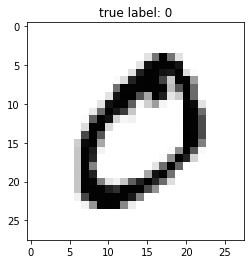

In [10]:
plot_digit(train_set_x, train_set_y, idx=0)

In [359]:
def transform(data, n_pca=2, scale = True):
    """
    Applying PCA and MinMaxScaler
    """
    pca = PCA(n_components=n_pca)
    t_data = pca.fit_transform(data)
    if scale:
      t_data = (t_data - t_data.min(axis=0)) / (t_data.max(axis=0) - t_data.min(axis=0))
    return t_data


def error(y_test, y_pred):
    """
    Prediction error we will use in this assignment
    """
    return (y_pred != y_test).mean()


def compute_confusion_matrix(y_test, y_pred):
    """
    Computing a confusion matrix
    """

    K = len(np.unique(y_test))
    result = np.zeros((K, K))

    for i in range(len(y_test)):
      result[y_test[i]][y_pred[i]] += 1

    return result

###Exercise 1: Nearest Neighbor Classifier###

We use PCA to leave 2 column features. Then we scale data to [0,1] range

In [377]:
train_x = transform(train_set_x, scale = True)
test_x = transform(test_set_x, scale = True)

In [245]:
print(train_x.shape, train_y.shape, test_x.shape, test_y.shape)

(12665, 2) (12665,) (2115, 2) (2115,)


**Mathematical expression of the algorithm**:

We define similarity according to the Euclidean distance:


$$d(x, {x}') = \sqrt{(x_{1} - {x}'_{1})^2 + ... + (x_{n} - {x}'_{n})^2}$$

Given a positive integer K, an unseen observation x and a similarity metric d, KNN classifier performs two steps:

   - It runs through the whole dataset computing distance $d$ between each unseen point $x$ and each training observation. We'll take the K points in the training data that are closest to $x$ in the set of unseen points $\mathcal{A}$. 

   - Then it estimates the conditional probability for each class, that is the fraction of points in $\mathcal{A}$ with that given class label. ($I(x)$ - indicator function)
   
   $$P(y = j | X = x) = \frac{1}{K} \sum_{i \in \mathcal{A}} I(y^{(i)} = j)$$
   Finally, input x gets assigned to the class with the largest probability.

In [378]:
def euclidian_dist(x_train, x_unseen):
    """
    Calculating euclidian distance between each pairs of known and unknown points
    """
    m = x_train.shape[0] # number of examples in x_train
    k = x_unseen.shape[0] # number of examples in x_unseen
  
    # each row of dists array represents the distances from i-th unseen example to train points
    dists = np.zeros((k,m))

    for i in range(k):
      diffs = x_train - x_unseen[i, :]
      dists_sq = (diffs*diffs).sum(axis=1)
      dists[i,:] = np.sqrt(dists_sq)
            
    return dists

def k_nearest_n(x_train, y_train, x_unseen, k, dists = euclidian_dist):
    """
    KNN implementation
    """
    
    num_pred = x_unseen.shape[0]
    n_nearest = []
    y_pred = []
    dists = dists(x_train, x_unseen)
    
    for j in range(num_pred):
        sort_index = np.argsort(dists[j])[:k]
        closest_y = [y_train[i] for i in sort_index]
        n_nearest.append(closest_y)

    for i in n_nearest:
        y_pred.append(np.argmax(np.bincount(i)))
         
    return np.asarray(y_pred)

We can plot decision boundaries for k from 1 to 5

K=1


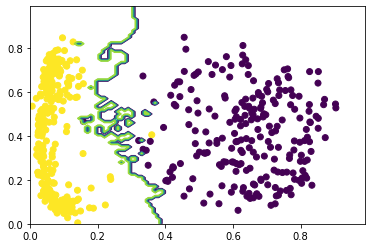

K=2


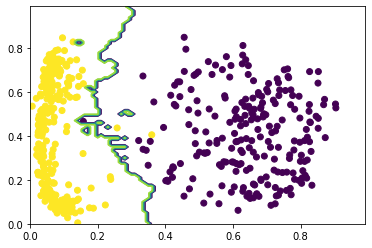

K=3


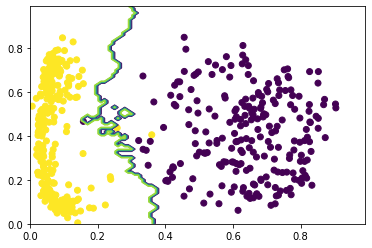

K=4


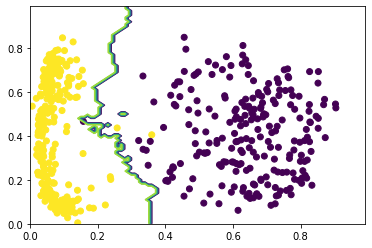

K=5


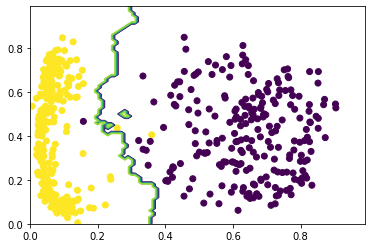

In [247]:
for i in range(1, 6):
  xx, yy = np.meshgrid(np.arange(0, 1, .01), np.arange(0, 1, .01))
  Z = k_nearest_n(train_x, train_y, np.c_[xx.ravel(), yy.ravel()], i)
  Z = Z.reshape(xx.shape)
  print(f"K={i}")
  plt.figure()
  plt.contour(xx, yy, Z)
  plt.scatter(train_x[:500, 0], train_x[:500, 1], c=train_y[:500])
  plt.show()

The larger k is, the smoother the classification boundary, and visualization proves that. But a small value of k means that noise will have a higher influence on the result, that is why k=1 gave the worst result.

We can see that in our case k=3 gave the smallest error on test dataset

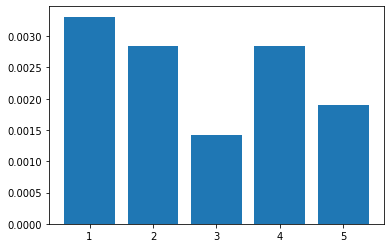

In [249]:
k_s = [i for i in range(1,6)]
values = [error(test_y, k_nearest_n(train_x, train_y, test_x, k)) for k in k_s]
plt.bar(k_s, values)
plt.show()

KNN with the best hyperparameter (k=3) resulted in incorrect prediction of only 3 examples from the test set.

In [381]:
compute_confusion_matrix(test_y, k_nearest_n(train_x, train_y, test_x, 3)).astype(int)

array([[ 979,    1],
       [   2, 1133]])

### Exercise 2: MED and GED Classifiers### 

 **Generating data for 20D and 2D case**

In [231]:
train_20d_x  = transform(train_set_x, n_pca=20)
test_20d_x = transform(test_set_x, n_pca=20)

print(train_20d_x.shape, train_y.shape, test_20d_x.shape, test_y.shape)

(12665, 20) (12665,) (2115, 20) (2115,)


In [191]:
train_2d_x = transform(train_set_x, n_pca=2)
test_2d_x = transform(test_set_x, n_pca=2)

print(train_2d_x.shape, train_y.shape, test_2d_x.shape, test_y.shape)

(12665, 2) (12665,) (2115, 2) (2115,)


**MED classifier implementation**

In [324]:
def MED_boundary(x_train, y_train, dists = euclidian_dist):

    class_list = np.unique(y_train, axis=0)

    centroids = np.zeros((len(class_list), x_train.shape[1])) # each row is a centroid
    for i in range(len(class_list)): # for each class, we evaluate its centroid
        temp = np.where(y_train==class_list[i])[0]
        centroids[i,:] = np.mean(x_train[temp], axis=0)

    n = len(centroids)
    bndrs = []
    for i in range(n):
        for j in range(n):
            if i < j:
                z_i, z_j = centroids[i], centroids[j]
                w_T, w_0 = (z_i - z_j).T, 0.5 * (z_j.T@z_j - z_i.T@z_i)
                bndrs.append([w_T, w_0 / np.linalg.norm(w_T)])

    return centroids, bndrs


def MED_clf(x_unseen, centroids):
    """
    Uses centroids for prediction
    """

    y_pred = np.argmin(
        euclidian_dist(x_unseen, centroids), # distance between each pair of the two collections of inputs
        axis=0
    )
    return y_pred

**GED classifier implementation**

In [368]:
def inv_cov(A):
    """
    Calculating inverse of covariance matrix
    in 2D case we use low-level calculations
    in other cases eigenvalue decomposition is used
    """
    if A.shape[0] == 2:
      a, b, c, d = A[0,0], A[0,1], A[1,0], A[1,1]
      return np.asarray([[d/(a*d-b*c), -b/(a*d-b*c)],
              [-c/(a*d-b*c), a/(a*d-b*c)]])

    v,m = np.linalg.eig(A)
    return m@np.diag(1/v)@m.T

def GED_boundary(A, B, test_data):
    """
    A and B are matrices of shape (num_examples, num_features)
    test_data - sample of size (num_examples, num_features)
    """
    m_A = np.mean(A, axis=0)
    m_B = np.mean(B, axis=0)
    inv_cov_A = inv_cov(np.cov(A.T))
    inv_cov_B = inv_cov(np.cov(B.T))


    Q0 = inv_cov_A - inv_cov_B
    Q1 = 2*(m_B.T@inv_cov_B - m_A.T@inv_cov_A)
    Q2 = m_A.T@inv_cov_A@m_A - m_B.T@inv_cov_B@m_B
    

    return (test_data.T*(Q0@test_data.T)).sum(axis=0) + Q1@test_data.T + Q2

def GED_clf(A, B, test_data, boundary=GED_boundary):
    """
    Uses result of a boundary to convert it to 0 or 1
    """
    return np.asarray(boundary(A, B, test_data) > 0).astype(int)

**Result of MED in 2D case**

In [361]:
centroids, bndrs = MED_boundary(train_2d_x, train_y)

In [362]:
y_pred2d_med = MED_clf(test_2d_x, centroids)
error(test_y, y_pred2d_med)

0.005673758865248227

In [363]:
compute_confusion_matrix(test_y, y_pred2d_med)

array([[ 968.,   12.],
       [   0., 1135.]])

Visualising a boundary using a slope and intercept

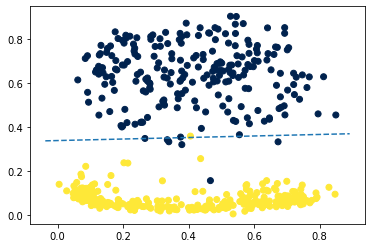

In [329]:
decision_boundary = bndrs[0]
plt.figure()
plt.scatter(train_2d_x[:500, 1], train_2d_x[:500, 0], c=train_y[:500], cmap='cividis')
axes = plt.gca()
x_vals = np.array(axes.get_xlim())
y_vals = -decision_boundary[1] + decision_boundary[0] * x_vals
plt.plot(x_vals, y_vals, '--')
plt.show()

**Result of GED in 2D case**

In [369]:
cl0 = train_2d_x[train_y == 0]
cl1 = train_2d_x[train_y == 1]

y_pred = GED_clf(cl0, cl1, test_x)

In [370]:
error(test_y, y_pred)

0.003309692671394799

In [372]:
compute_confusion_matrix(test_y, y_pred)

array([[ 980.,    0.],
       [   7., 1128.]])

Visualizing decision boundary (contour line with levels=0) of GED.

The error shows us that GED classifies worse then KNN with k=3.

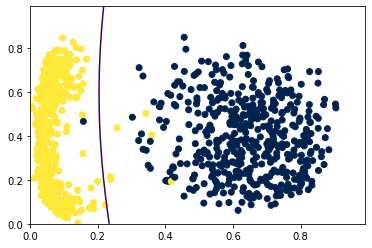

In [330]:
xx, yy = np.meshgrid(np.arange(0, 1, .01), np.arange(0, 1, .01))

Z = GED_boundary(cl0, cl1, np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure()
plt.contour(xx, yy, Z, levels=(0,))
plt.scatter(train_2d_x[:1000, 0], train_2d_x[:1000, 1], c=train_y[:1000], cmap = 'cividis')
plt.show()

We can see that in 2D case GED gave better results, that can be explained by the more complex nin-linear structure of decision boundary. 


Both GED and MED are discriminative algorithms - they try to find boundaries between two classes, and in our case they worked not as good as KNN in 2D case. But because of the curse of dimensionality, KNN is not appropriate for high-dimensional data, so in 20D case we did not implement it. Also in our case there were not many outliers, which also could possibly make KNN a weaker classifier.

**Comparing results of MED and GED in 20D case**

GED failed to classify the points correctly, while MED gave results even more precise.

In [373]:
cl0 = train_20d_x[train_y == 0]
cl1 = train_20d_x[train_y == 1]

y_pred20d_ged = GED_clf(cl0, cl1, test_20d_x)

centroids, bndrs = MED_boundary(train_20d_x, train_y)
y_pred20d_med = MED_clf(test_20d_x, centroids)

In [374]:
error(test_y, y_pred20d_med)

0.004728132387706856

In [375]:
error(test_y, y_pred20d_ged)

0.32671394799054376

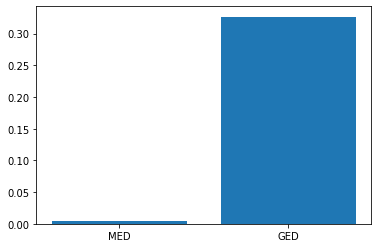

In [356]:
clfs = ['MED', 'GED']
values = [error(test_y, y_pred20d_med), error(test_y, y_pred20d_ged)]
plt.bar(clfs, values)
plt.show()